In [4]:
! pip install git+https://www.github.com/deepmind/pycolab.git

  Cloning https://www.github.com/deepmind/pycolab.git to /tmp/pip-me0s4o0c-build
  Running setup.py install for pycolab ... - \ done


# 1. Block Maze

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pycolab.plot
from pycolab import ascii_art
from pycolab.prefab_parts import sprites as prefab_sprites

GAME_ART = ['###########',
            '#        G#',
            '#         #',
            '#         #',
            '#a#######b#',
            '#         #',
            '#   P     #',
            '###########',
            ]

class PlayerSprite(prefab_sprites.MazeWalker):

    def __init__(self, corner, position, character, initial_pos = (6,4)):
        """Inform superclass that we can't walk through walls."""
        super(PlayerSprite, self).__init__(
            corner, position, character, impassable='#a')
        self.initial_pos = initial_pos
        self.timestep = 0

    def update(self, actions, board, layers, backdrop, things, the_plot):
        del layers, backdrop, things  # Unused.

        # Apply motion commands.
        if actions == 0:  # walk upward?
            self._north(board, the_plot)
        elif actions == 1:  # walk downward?
            self._south(board, the_plot)
        elif actions == 2:  # walk leftward?
            self._west(board, the_plot)
        elif actions == 3:  # walk rightward?
            self._east(board, the_plot)

        # See if we've found the mystery spot.
        if self.position == (1, 9):
            the_plot.add_reward(1.0)
            self._teleport(self.initial_pos)
        else:
            the_plot.add_reward(0)

        self.timestep += 1
        if self.timestep == 1000:
#             print('change environment')
            self._impassable='#b'


class DynaAgent:
    '''
    A Tabular Dyna-Q learning agent
    epsilon-greedy;
    learns a model
    '''

    def __init__(self, game, nb_states, nb_actions, init_state, n, epsilon=0.2, gamma=0.95, alpha=0.1, k=1e-3, plus=False):
        self.game = game
        self.nb_states = nb_states
        self.nb_actions = nb_actions
        self.epsilon = epsilon
        # initial/current state
        self.init_state = init_state
        self.state = init_state
        self.gamma = gamma
        self.alpha = alpha
        self.n = n
        self.k = k
        self.plus = plus
        # initialize something, found out that using random is much better than zeros
        self.state_action = np.random.rand(nb_states, nb_actions)
        # assuming a deterministic environment, therefore only destination is stored rather than a distribution of state space
        self.model_trans = np.zeros((nb_states, nb_actions), dtype=int)
        self.model_reward = np.zeros((nb_states, nb_actions))
        if self.plus:
          self.last_visit = np.zeros((nb_states, nb_actions))

    def breaktie_argmax(self, vector):
        return np.random.choice(np.where(vector == vector.max())[0])

    def begin_learning(self, max_timestep=3000):
        time_step = 0
        cumulative_reward = np.zeros(max_timestep+1)

        while time_step < max_timestep:
            if np.random.rand() < self.epsilon:
                action = np.random.randint(self.nb_actions)
            else:
                # go greedy way
                action = self.breaktie_argmax(self.state_action[self.state, :])
            if self.plus:
              self.last_visit[self.state, action] = time_step + 1
            obs, reward, gamma = self.game.play(action)
            next_state = np.argmax(np.array(obs.layers['P'], dtype=int).flatten())
            # direct rl
            self.state_action[self.state, action] += self.alpha * (
                    reward + self.gamma * np.max(self.state_action[next_state, :]) - self.state_action[
                self.state, action])
            # update knowledge of the model
            self.model_trans[self.state, action] = next_state
            self.model_reward[self.state, action] = reward
            self.state = next_state
            # dyna-q planning, the following codes and logic rely heavily on the deterministic environment guarantees;
            # also under the assumption that state 0 is not reachable.
            for  i in range(self.n):
                fantasied_state = np.random.choice(np.where(self.model_trans.sum(axis=1)!=0)[0])
                if self.plus:
                  fantasied_action = np.random.choice(np.arange(self.nb_actions, dtype=int))
                else:
                  fantasied_action = np.random.choice(np.where(self.model_trans[fantasied_state,:] != 0)[0])
                fantasied_next_state = self.model_trans[fantasied_state,fantasied_action]
                fantansied_reward = self.model_reward[fantasied_state,fantasied_action]
                if self.plus:
                  fantansied_reward += self.k * np.sqrt(time_step+1 - self.last_visit[fantasied_state,fantasied_action])
                self.state_action[fantasied_state, fantasied_action] += self.alpha * (
                        fantansied_reward + self.gamma * np.max(self.state_action[fantasied_next_state, :]) - self.state_action[
                    fantasied_state, fantasied_action])

            time_step += 1
            cumulative_reward[time_step] = cumulative_reward[time_step-1] + reward

            # check termination condition; starts a new game
            if gamma == 0:
                self.state =self.init_state
        return np.array(cumulative_reward)[1:]


def make_game():
  return ascii_art.ascii_art_to_game(
      GAME_ART, what_lies_beneath=' ',
      sprites={'P': PlayerSprite})

Small experiment

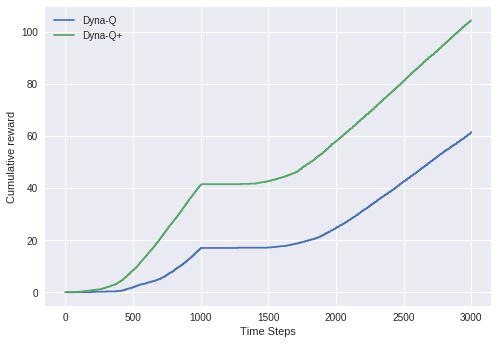

In [62]:
iterations = 10
rewards = []
rewards_plus = []
for i in range(iterations):
    game = make_game()
    obs, re, dis = game.its_showtime()
    initial_state = np.argmax(np.array(obs.layers['P'],dtype=int).flatten())
    nb_states = np.array(obs.layers['P'], dtype=int).flatten().shape[0]
    nb_actions = 4
    n = 50
    agent = DynaAgent(game,nb_states,nb_actions,initial_state,n)
    rewards.append(agent.begin_learning())

    game_plus = make_game()
    game_plus.its_showtime()
    agent = DynaAgent(game_plus, nb_states, nb_actions, initial_state, n, plus=True)
    rewards_plus.append(agent.begin_learning())
rewards = np.array(rewards)
rewards_plus = np.array(rewards_plus)
plt.figure()
plt.plot(rewards.mean(axis=0), label='Dyna-Q')
plt.plot(rewards_plus.mean(axis=0), label='Dyna-Q+')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative reward')
plt.legend()
plt.show()

## Some observations:
1. Initialize state-action values with random values is better than initializing with zeros: great different can be observed.
2. Dyna-Q+ allows arbitrary action to be tried at the planning stage, notwithstanding whether it has been tried before.
3. It might happen in an individual iteration that the Dyna-Q or Dyna-Q+ agent fails to find another path until it meets the 3000 time steps limit when the environment changes, a phenomenon affected by tie-breaking and the $\epsilon$ value.

## 1.1 More rigorous experiment

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

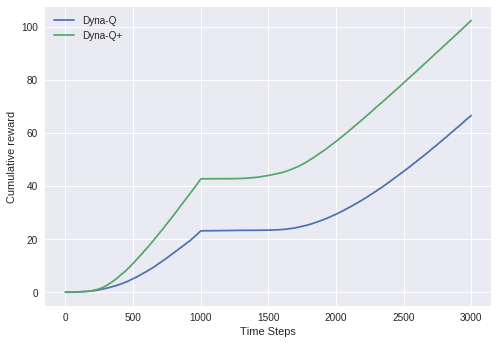

In [51]:
    iterations = 100
    rewards = []
    rewards_plus = []
    for i in range(iterations):
        game = make_game()
        obs, re, dis = game.its_showtime()
        initial_state = np.argmax(np.array(obs.layers['P'],dtype=int).flatten())
        nb_states = np.array(obs.layers['P'], dtype=int).flatten().shape[0]
        nb_actions = 4
        n = 50
        agent = DynaAgent(game,nb_states,nb_actions,initial_state,n)
        rewards.append(agent.begin_learning())

        game_plus = make_game()
        game_plus.its_showtime()
        agent = DynaAgent(game_plus, nb_states, nb_actions, initial_state, n, plus=True)
        rewards_plus.append(agent.begin_learning())
        print('iteration: {}'.format(i))
    rewards = np.array(rewards)
    rewards_plus = np.array(rewards_plus)
    plt.figure()
    plt.plot(rewards.mean(axis=0), label='Dyna-Q')
    plt.plot(rewards_plus.mean(axis=0), label='Dyna-Q+')
    plt.xlabel('Time Steps')
    plt.ylabel('Cumulative reward')
    plt.legend()
    plt.show()

Averaged over 100 iterations, the curve becomes quite stable, and we can see that Dyna-Q+ outperforms Dyna-Q, when epsilon is 0.2, learning rate is 0.1, and $\kappa$ is 0.001.

## 1.2 Some hyperparameter comparison

Dyna-Q epsilon: 0.15, n: 20
Dyna-Q epsilon: 0.15, n: 30
Dyna-Q epsilon: 0.15, n: 50
Dyna-Q epsilon: 0.2, n: 20
Dyna-Q epsilon: 0.2, n: 30
Dyna-Q epsilon: 0.2, n: 50
Dyna-Q plus epsilon: 0.15, kappa: 0.0001, n: 20
Dyna-Q plus epsilon: 0.15, kappa: 0.0001, n: 30
Dyna-Q plus epsilon: 0.15, kappa: 0.0001, n: 50
Dyna-Q plus epsilon: 0.15, kappa: 0.001, n: 20
Dyna-Q plus epsilon: 0.15, kappa: 0.001, n: 30
Dyna-Q plus epsilon: 0.15, kappa: 0.001, n: 50
Dyna-Q plus epsilon: 0.2, kappa: 0.0001, n: 20
Dyna-Q plus epsilon: 0.2, kappa: 0.0001, n: 30
Dyna-Q plus epsilon: 0.2, kappa: 0.0001, n: 50
Dyna-Q plus epsilon: 0.2, kappa: 0.001, n: 20
Dyna-Q plus epsilon: 0.2, kappa: 0.001, n: 30
Dyna-Q plus epsilon: 0.2, kappa: 0.001, n: 50


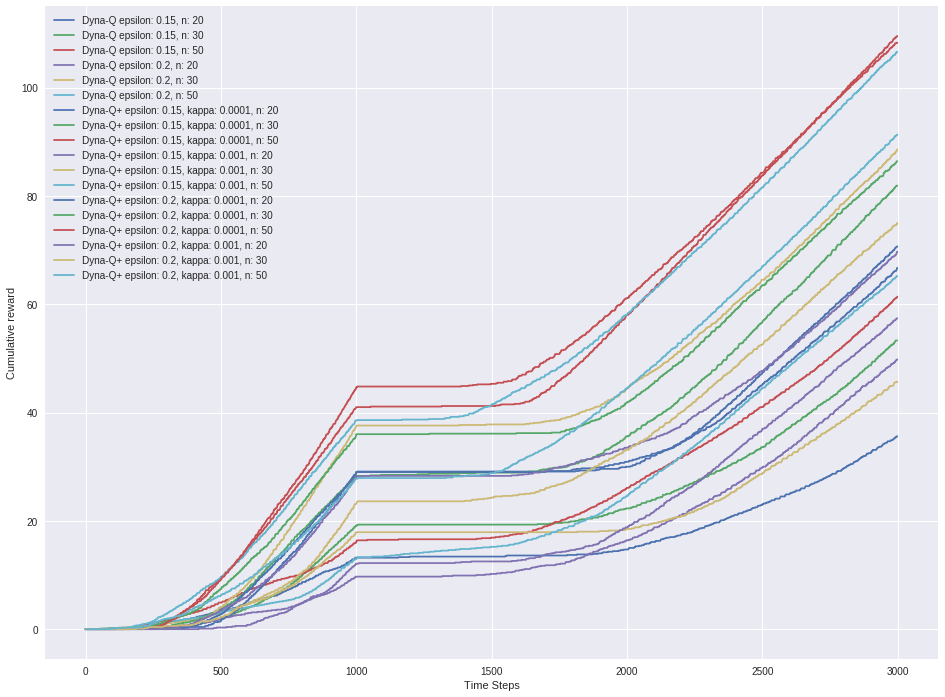

In [8]:
import itertools
iterations = 10
k = [1e-4, 1e-3]
epsilon = [0.15, 0.2]
ns = [20, 30, 50]
plt.figure(figsize=(16,12))
for e, n in itertools.product(epsilon, ns):
  print('Dyna-Q epsilon: {0}, n: {1}'.format(e, n))
  rewards = []
  for i in range(iterations):
      game = make_game()
      obs, re, dis = game.its_showtime()
      initial_state = np.argmax(np.array(obs.layers['P'],dtype=int).flatten())
      nb_states = np.array(obs.layers['P'], dtype=int).flatten().shape[0]
      nb_actions = 4
      agent = DynaAgent(game,nb_states,nb_actions,initial_state, epsilon=e, n=n)
      rewards.append(agent.begin_learning())
  rewards = np.array(rewards)
  plt.plot(rewards.mean(axis=0), label='Dyna-Q epsilon: {0}, n: {1}'.format(e, n))

for e, kappa, n in itertools.product(epsilon, k, ns):
  print('Dyna-Q plus epsilon: {0}, kappa: {1}, n: {2}'.format(e, kappa, n))
  rewards = []
  for i in range(iterations):
      game = make_game()
      obs, re, dis = game.its_showtime()
      initial_state = np.argmax(np.array(obs.layers['P'],dtype=int).flatten())
      nb_states = np.array(obs.layers['P'], dtype=int).flatten().shape[0]
      nb_actions = 4
      agent = DynaAgent(game,nb_states,nb_actions,initial_state, epsilon=e, n=n, k=kappa, plus=True)
      rewards.append(agent.begin_learning())
  rewards = np.array(rewards)
  plt.plot(rewards.mean(axis=0), label='Dyna-Q+ epsilon: {0}, kappa: {1}, n: {2}'.format(e, kappa, n))
plt.xlabel('Time Steps')
plt.ylabel('Cumulative reward')
plt.legend()

This went a little bit out of control...But it did give us an idea that Dyna-Q series algorithm can handle non-stationary environment to the extent that its original estimates are optimistic (Or to say the environment is going downhill).

Dyna-Q plus kappa: 0.001, n: 5
Dyna-Q plus kappa: 0.001, n: 20
Dyna-Q plus kappa: 0.001, n: 30
Dyna-Q plus kappa: 0.001, n: 50
Dyna-Q plus kappa: 0.001, n: 100
Dyna-Q plus kappa: 0.001, n: 150
Dyna-Q plus kappa: 0.001, n: 200
Dyna-Q plus kappa: 0.0001, n: 5
Dyna-Q plus kappa: 0.0001, n: 20
Dyna-Q plus kappa: 0.0001, n: 30
Dyna-Q plus kappa: 0.0001, n: 50
Dyna-Q plus kappa: 0.0001, n: 100
Dyna-Q plus kappa: 0.0001, n: 150
Dyna-Q plus kappa: 0.0001, n: 200


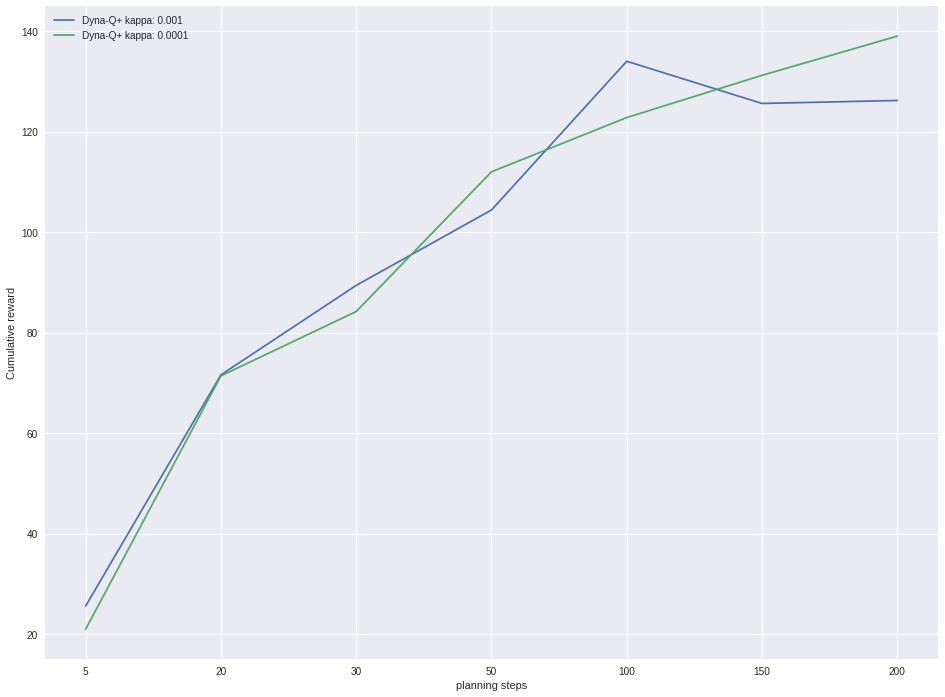

In [7]:
import matplotlib.pyplot as plt
iterations = 5
ns = [5, 20, 30, 50, 100, 150, 200]
k = [1e-3, 1e-4]
x = np.arange(len(ns),dtype=int)
plt.figure(figsize=(16,12))
for kappa in k:
  cul_reward = []
  for n in ns:
    print('Dyna-Q plus kappa: {0}, n: {1}'.format(kappa, n))
    rewards = []
    for i in range(iterations):
        game = make_game()
        obs, re, dis = game.its_showtime()
        initial_state = np.argmax(np.array(obs.layers['P'],dtype=int).flatten())
        nb_states = np.array(obs.layers['P'], dtype=int).flatten().shape[0]
        nb_actions = 4
        agent = DynaAgent(game,nb_states,nb_actions,initial_state, epsilon=0.2, n=n, k=kappa, plus=True)
        rewards.append(agent.begin_learning())
    rewards = np.array(rewards)
    cul_reward.append(rewards.mean(axis=0)[-1])
  plt.plot(x, cul_reward, label='Dyna-Q+ kappa: {0}'.format(kappa))
plt.xticks(x,ns)
plt.xlabel('planning steps')
plt.ylabel('Cumulative reward')
plt.legend()

For dyna-Q+ algorithm, $\kappa$ at 0.0001 is better than 0.001 (0.01 is catastrophic), and a larger steps at the planning stage is generally better — and a $\kappa$ at 0.0001 allows for greater improvement with bigger time steps.

# 2. Shortcut Maze

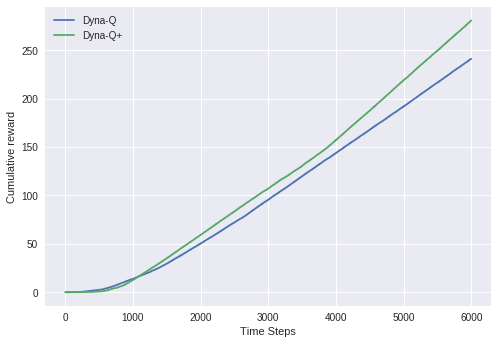

In [61]:
# very simple extension from the last one
import numpy as np
import matplotlib.pyplot as plt

import pycolab.plot
from pycolab import ascii_art
from pycolab.prefab_parts import sprites as prefab_sprites

NEW_GAME_ART = ['###########',
                '#        G#',
                '#         #',
                '#         #',
                '# #######b#',
                '#         #',
                '#   P     #',
                '###########',
               ]

class NewPlayerSprite(prefab_sprites.MazeWalker):

    def __init__(self, corner, position, character, initial_pos = (6,4)):
        """Inform superclass that we can't walk through walls."""
        super(NewPlayerSprite, self).__init__(
            corner, position, character, impassable='#b')
        self.initial_pos = initial_pos
        self.timestep = 0

    def update(self, actions, board, layers, backdrop, things, the_plot):
        del layers, backdrop, things  # Unused.

        # Apply motion commands.
        if actions == 0:  # walk upward?
            self._north(board, the_plot)
        elif actions == 1:  # walk downward?
            self._south(board, the_plot)
        elif actions == 2:  # walk leftward?
            self._west(board, the_plot)
        elif actions == 3:  # walk rightward?
            self._east(board, the_plot)

        # See if we've found the mystery spot.
        if self.position == (1, 9):
            the_plot.add_reward(1.0)
            self._teleport(self.initial_pos)
        else:
            the_plot.add_reward(0)

        self.timestep += 1
        if self.timestep == 3000:
            self._impassable='#'

def make_another_game():
  return ascii_art.ascii_art_to_game(
      NEW_GAME_ART, what_lies_beneath=' ',
      sprites={'P': NewPlayerSprite})

# Only a simple experiment this time, to give us an idea of the limitation.
if __name__ == '__main__':
    iterations = 10
    rewards = []
    rewards_plus = []
    for i in range(iterations):
        game = make_another_game()
        obs, re, dis = game.its_showtime()
        initial_state = np.argmax(np.array(obs.layers['P'],dtype=int).flatten())
        nb_states = np.array(obs.layers['P'], dtype=int).flatten().shape[0]
        nb_actions = 4
        n = 50
        agent = DynaAgent(game,nb_states,nb_actions,initial_state, n)
        rewards.append(agent.begin_learning(max_timestep=6000))
        game = make_another_game()
        game.its_showtime()
        agent = DynaAgent(game, nb_states, nb_actions, initial_state, n, plus=True)
        rewards_plus.append(agent.begin_learning(max_timestep=6000))
    rewards = np.array(rewards)
    rewards_plus = np.array(rewards_plus)
    plt.figure()
    plt.plot(rewards.mean(axis=0), label='Dyna-Q')
    plt.plot(rewards_plus.mean(axis=0), label='Dyna-Q+')
    plt.xlabel('Time Steps')
    plt.ylabel('Cumulative reward')
    plt.legend()

This figure coincides with the conclusion we arrived at in class. Dyna-Q is simply not aware of the new optimal path when environment changes, whereas Dyna-Q+ still manages to find it as Dyna-Q+ is encouraged to re-explore long-not-visited state-action pairs.

# 3. Experience Replay
In a deterministic environment as the one used in Block Maze and Shortcut Maze, the experience quadruple $(S_t, A_t, R_{t+1}, S_{t+1})$ is remembered in the Dyna-Q agent's model transition matrix and model reward matrix, by 
$$P(S_{t+1}|S_{t},A_{t})=1$$
$$P(s'|S_{t},A_{t})=0\quad for\quad s'\in \mathbf{S}\quad and\quad s'!= S_{t+1}$$
$$R(S_{t},A_{t})=R_{t+1}$$
In the planning stage, the agent randomly draws a sample state and a sample action, the pair of which has been previously visited, then consults its model transition matrix and model reward matrix for the next state and reward. The quadruple formed in the planning stage is actually a former experience.

Experience replay also allows for a sequence of experiences to be replayed, especially in a backward order; TD($\lambda$) can be as well utilized here to give a more sophisticated temporal error signal. Dyna-Q/Q+ algorithm instead can only replay a stand-alone experience at a time, however, adaptation to replaying a sequence and applying TD($\lambda$) is quite strict forward — just allows an arbitrary number of time steps in the planning stage, and updates the state-action pair values using TD($\lambda$) method.